# Problem Set 5, due June 1 at 11:59 pm.

As usual, you are highly encouraged to *start this problem set early!*  My best guess (no guarantees!) is that Part 1 will be conceptually easy but perhaps time consuming.  Parts 2 and 3 are medium difficult, but there are plenty of opportunities to get confused with python data structures, so if you're going to get stuck, get stuck (and unstuck) early! Part 4 will give you an opportunity to get some intuition with PCA.

Note that the two extra credit problems have the potential to be quite challenging and time consuming. Make sure to do everything else in the problem set before you tackle the extra credit.

To get started, download the files "reviews.csv" and "movies.dat" from Canvas.

For this assignment, the following libraries may be useful:

* [numpy](http://docs.scipy.org/doc/numpy-dev/user/index.html), for arrays
* [scikit-learn](http://scikit-learn.org/stable/), for machine learning
* [pandas](http://pandas.pydata.org/), for data frames
* [matplotlib](http://matplotlib.org/), for plotting

In particular, I suggest you familiarize yourself with the following aspects of these libraries, which are not required but which might make your life easier:

* `DataFrame` and other basic [data structures](http://pandas.pydata.org/pandas-docs/stable/dsintro.html) in pandas
* [`groupby`](http://pandas.pydata.org/pandas-docs/stable/groupby.html), `unique`,  and other simple aggregation functions
* [`CountVectorizer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) for working with text in sklearn.
* [`MultinomialNB`](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) for Naive Bayes
* Simple tools for [Cross-Validation](http://scikit-learn.org/stable/modules/cross_validation.html) in sklearn

Make sure they load properly with the following code block:

In [25]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#hint: Consult the scikit-learn documentation to
#      learn about what these classes do do
from  sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

## Introduction to the assignment

In this assignment, you'll be analyzing movie reviews in an attempt to determine whether movies are good or bad.  I've downloaded a large number of movie reviews from the [Rotten Tomatoes](http://www.rottentomatoes.com) website, which are available in the file "reviews.csv" on Canvas.  I've also put a file "movies.dat" on Canvas that contains metadata for ~65,000 different movies

If you've never seen Rotten Tomatoes before, go spend a few minutes familiarizing yourself with the website.  It's a meta-review website that aggregates movie reviews from a large number of critics.  Here's what the page for this year's likely [Oscar winner](http://www.rottentomatoes.com/m/the_revenant_2015/) looks like.  Note in particular the section on "Critic Reviews" at the bottom -- that's the content that has been scraped and put in the reviews.csv file.  Also note that each movie is given a quantitative score on the Tomatometer which is used to classify the movie as either Fresh (good) or Rotten (bad).

Your mission is to develop a classifier to determine whether a movie is Fresh or Rotten based on the contents of the reviews given to the movie.  As usual, we'll start out with some exploratory data analysis.

---

## Part 1: Descriptive analysis

Before beginning the "real" work, dig into the data a bit do see what you're dealing with.  Begin by loading the datasets and dropping rows that have missing data:

In [2]:
reviews = pd.read_csv('reviews.csv')
movies = pd.read_csv("movies.dat", delimiter='\t')

reviews = reviews[~reviews.quote.isnull()]
reviews = reviews[reviews.fresh != 'none']
reviews = reviews[reviews.quote.str.len() > 0]

### 1.1: Basic features of the dataset

Answer the following questions by having your python code directly print the answers:

* How many unique reviews (quotes) are in the `reviews` dataset?
* How many unique reviewers (critics) are in the `reviews` dataset?
* How many unique movies are in the `reviews` dataset?
* How many unique movies are in the *`movies`* dataset?
* How many different publications have reviews in the `reviews` dataset?


In [7]:
print("Number of reviews: %i" % len(reviews))
print("Unique reviewers: %i" % len(reviews.critic.unique()))
print("Unique movies in `reviews` dataset: %i" % len(reviews.imdb.unique()))
print("Unique movies in `movies` dataset: %i" % len(movies.imdbID.unique()))
print("Unique publications in `reviews` dataset: %i" % len(reviews.publication.unique()))

Number of reviews: 13419
Unique reviewers: 541
Unique movies in `reviews` dataset: 1720
Unique movies in `movies` dataset: 9423
Unique publications in `reviews` dataset: 64


### 1.2 Number of reviews per reviewer

Using the `reviews` dataset, create a histogram showing the distribution of the number of reviews per reviewer.  Create the bin width (x-axis) to be 1 unit wide, and the range of the axis to be from 0 to 30.  Scale the y-axis to show the logarithm of (count of) the number of reviews.  Label your axes and make your histogram look professional.

Text(0,0.5,'Frequency')

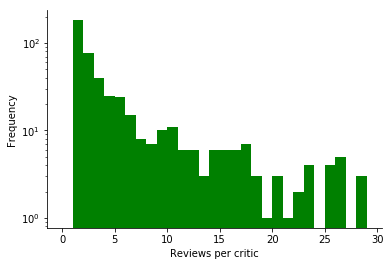

In [8]:
ax = plt.subplot(111)
plt.hist(reviews.groupby(['critic']).size(), bins = np.arange(0, 30, 1), color="green")
plt.yscale('log')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel('Reviews per critic')
plt.ylabel('Frequency')

### 1.3 Zoom in on a few reviewers
Find the 30 critics with the most reviews, and list their names in a table along with (a) the name of the publication they work for, (b) the date of their first review, and (c) the date of their last review

*hint: use the groupby function to do this quickly*

In [16]:
# groupby critic and publication, including their first and last review date
tab = reviews.groupby(['critic', 'publication']).agg({'review_date':[max,min],
                                               'critic':len})

# sort by number of reviews, subset the 30 most prolific reviewers
tab.sort_values(by=[('critic','len')],ascending=False)[0:30] 

review_date  \
                                                            max   
critic             publication                                    
Roger Ebert        Chicago Sun-Times        2013-06-11 00:00:00   
James Berardinelli ReelViews                2012-02-07 00:00:00   
Janet Maslin       New York Times           2010-09-07 00:00:00   
Variety Staff      Variety                  2012-08-15 00:00:00   
Jonathan Rosenbaum Chicago Reader           2013-10-22 00:00:00   
Desson Thomson     Washington Post          2012-10-08 00:00:00   
Geoff Andrew       Time Out                 2012-04-05 00:00:00   
Dave Kehr          Chicago Reader           2013-11-06 00:00:00   
Kenneth Turan      Los Angeles Times        2013-10-05 00:00:00   
Mick LaSalle       San Francisco Chronicle  2009-11-25 00:00:00   
Owen Gleiberman    Entertainment Weekly     2011-09-07 00:00:00   
Rita Kempley       Washington Post          2013-11-02 00:00:00   
Todd McCarthy      Variety                  2012-10-09 00:00:00   
Joe Baltake        Sacramento Bee           2004-12-22 00:00:00   
Vincent Canby      New York Times           2013-07-29 00:00:00   
Hal Hinson         Washington Post          2013-06-26 00:00:00   
Susan Stark        Detroit News             2002-10-25 00:00:00   
Stephen Holden     New York Times           2009-02-06 00:00:00   
Derek Adams        Time Out                 2009-10-04 00:00:00   
Kevin Thomas       Los Angeles Times        2013-11-02 00:00:00   
Peter Stack        San Francisco Chronicle  2002-06-18 00:00:00   
Bosley Crowther    New York Times           2008-05-06 00:00:00   
Rick Groen         Globe and Mail           2009-08-14 00:00:00   
Edward Guthmann    San Francisco Chronicle  2003-04-04 00:00:00   
Lisa Schwarzbaum   Entertainment Weekly     2012-08-15 00:00:00   
Liam Lacey         Globe and Mail           2012-04-04 00:00:00   
Emanuel Levy       Variety                  2010-08-06 00:00:00   
Richard Schickel   TIME Magazine            2013-08-05 00:00:00   
Richard Corliss    TIME Magazine            2013-11-06 00:00:00   
Jay Boyar          Orlando Sentinel         2013-11-20 00:00:00   

                                                                critic  
                                                            min    len  
critic             publication                                          
Roger Ebert        Chicago Sun-Times        2000-01-01 00:00:00   1093  
James Berardinelli ReelViews                1800-01-01 00:00:00    833  
Janet Maslin       New York Times           2000-01-01 00:00:00    526  
Variety Staff      Variety                  2001-02-13 00:00:00    449  
Jonathan Rosenbaum Chicago Reader           1988-07-11 00:00:00    420  
Desson Thomson     Washington Post          2000-01-01 00:00:00    373  
Geoff Andrew       Time Out                 2005-08-11 00:00:00    361  
Dave Kehr          Chicago Reader           2000-01-01 00:00:00    317  
Kenneth Turan      Los Angeles Times        2000-01-01 00:00:00    282  
Mick LaSalle       San Francisco Chronicle  2000-01-01 00:00:00    280  
Owen Gleiberman    Entertainment Weekly     1800-01-01 00:00:00    241  
Rita Kempley       Washington Post          2000-01-01 00:00:00    236  
Todd McCarthy      Variety                  2000-01-01 00:00:00    223  
Joe Baltake        Sacramento Bee           2000-01-01 00:00:00    221  
Vincent Canby      New York Times           2000-01-01 00:00:00    207  
Hal Hinson         Washington Post          2000-01-01 00:00:00    174  
Susan Stark        Detroit News             2000-01-01 00:00:00    167  
Stephen Holden     New York Times           2000-01-01 00:00:00    166  
Derek Adams        Time Out                 2006-01-26 00:00:00    154  
Kevin Thomas       Los Angeles Times        2000-01-01 00:00:00    145  
Peter Stack        San Francisco Chronicle  2000-01-01 00:00:00    138  
Bosley Crowther    New York Times           2000-01-01 00:00:00    137  
Rick Groen     

### 1.4 Ratings over time

Using the `movies` dataset, create a plot that shows how the average rating per movie (rtAllCriticsRating) has evolved over time.  Do this by creating a scatterplot where the x-axis is the year in which the movie was released and the y-axis is rtAllCriticsRating.  Drop movies with 0 or unknown values to avoid biasing your results.  Then, create a scatterplot that has one <year,rating> point for each remaining movie, and pick an appropriate size/color/transparency for these points to ensure that the graph looks professional.  In other words, do not simply use the default settings, as this will produce a dense mess of dots that will be hard to interpret.  Finally, overlay on this scatterplot a line graph in orange showing how the average movie rating (the average of rtAllCriticsRating across all movies in a year) has changed over time.  Do you notice a trend?  What do you think it means?

C:\Users\ipdavies\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


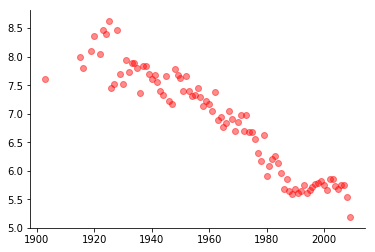

In [17]:
# First we need to convert the columns of type `object` in the movies df to type `numeric`
cols = movies.columns.drop(['title','spanishTitle','imdbPictureURL','rtID','rtPictureURL'])
movies[cols] = movies[cols].apply(pd.to_numeric, errors='coerce')

grouped = movies.dropna(subset=['rtAllCriticsRating'])[(movies['rtAllCriticsRating'] > 0)] # first remove NaN and 0 values
grouped = grouped.groupby('year', as_index=False)['rtAllCriticsRating'].mean() # then find average rating each year
                 
ax = plt.subplot(111)
plt.scatter(x=grouped['year'], y=grouped['rtAllCriticsRating'], color="red", alpha=0.45)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

The average All Critics Rating has steadily decreased from over 8.5 in 1925 to barely over 5.0 in 2010. My theory is that movies are actually getting worse over time -- lots of bad summer blockbusters, mindless slasher flicks, cliches, etc. But this may also be the "golden oldies" effect where older classics are seen with nostalgia.

## Part 2: Naive Bayes

Now it gets fun!  You are going to use a [Naive Bayes classifier](https://en.wikipedia.org/wiki/Naive_Bayes_classifier) to build a prediction model for whether a review is fresh or rotten, depending on the text of the review. Review the assigned readings on Canvas, as well as the relevant lecture notes before embarking on this journey.

### Using CountVectorizer

One thing that may help you in the following problems is the [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) object in Scikit-learn.  This will help you convert your raw text fields into "bag of words" vectors, i.e. a data structure that tells you how many times a particular word appears in a blurb.  Here's a simple example, make sure you understand what's going on!

In [19]:
from sklearn.feature_extraction.text import CountVectorizer

text = ['machine learning rocks', 'machine learning rules', 'rocks rocks rules']
print("Original text is\n", '\n'.join(text))

vectorizer = CountVectorizer(min_df=0)

# call `fit` to build the vocabulary
vectorizer.fit(text)

# call `transform` to convert text to a bag of words
x = vectorizer.transform(text)

# CountVectorizer uses a sparse array to save memory, but it's easier in this assignment to 
# convert back to a "normal" numpy array
x = x.toarray()

print()
print("Transformed text vector is \n", x)

# `get_feature_names` tracks which word is associated with each column of the transformed x
print()
print("Words for each feature:")
print(vectorizer.get_feature_names())

Original text is
 machine learning rocks
machine learning rules
rocks rocks rules

Transformed text vector is 
 [[1 1 1 0]
 [1 1 0 1]
 [0 0 2 1]]

Words for each feature:
['learning', 'machine', 'rocks', 'rules']


### 2.1 Create your X input and Y output

Using the `reviews` dataframe, compute a pair of numerical X, Y arrays where:
    
 * X is a `(nreview, nwords)` array. Each row corresponds to a bag-of-words representation for a single review. This will be the *input* to your model.
 * Y is a `nreview`-element 1/0 array, encoding whether a review is Fresh (1) or Rotten (0). This is the desired *output* from your model.
 
Make sure to remove items with no review text

In [20]:
"""
Function
--------
make_xy

Build a bag-of-words training set for the review data

Parameters
-----------
reviews : Pandas DataFrame
    The review data from above
    
vectorizer : CountVectorizer object (optional)
    A CountVectorizer object to use. If None,
    then create and fit a new CountVectorizer.
    Otherwise, re-fit the provided CountVectorizer
    using the reviews data
    
Returns
-------
X : numpy array (dims: nreview, nwords)
    Bag-of-words representation for each review.
Y : numpy array (dims: nreview)
    1/0 array. 1 = fresh review, 0 = rotten review

Examples
--------
X, Y = make_xy(reviews)
"""

def make_xy(reviews, vectorizer=None):
    if(vectorizer == None):
        vectorizer = CountVectorizer(min_df=0)
    corpus = reviews['quote'] # column with review text
    X = vectorizer.fit_transform(corpus) # fit and transform vectorizer to data
    X = X.toarray() # convert sparse matrix to dense matrix
    Y = np.array(reviews['fresh'].replace(['fresh','rotten'], [1,0])) # convert fresh/rotten to 1/0
    return X, Y


In [21]:
X, Y = make_xy(reviews.reset_index())

### 2.2 Test-Train split

Next, randomly split the data into two groups: a training set and a validation set.  You can do this manually, as you did in the prior problem set.  Or, use [`train_test_split`](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.train_test_split.html) to do this auto-magically.  See [this guide](http://scikit-learn.org/stable/modules/cross_validation.html) for a simple example of how `train_test_split` works.

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=0)

### 2.3 Naive Bayes with `MultinomialNB`
Use the training set to train a Naive Bayes classifier using the [`MultinomialNB`](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html)
 object.  Report the accuracy of this model on both the training and testing data.  What do you observe?  Interpret these results!

*Hint: This shouldn't take more than 5-10 lines of code to accomplish*



In [23]:
# First let's create a function to calculate root-mean squared error
def compute_rmse(predictions, yvalues):
    sigma = np.sum(np.square(np.array(predictions)-np.array(yvalues)))
    rmse = np.sqrt(sigma/len (predictions))
    return rmse

In [1]:
clf = MultinomialNB() # create classifier object
fitted_model = clf.fit(X_train, y_train) # fit our classifier to the training data
print("CV score: ", cross_val_score(fitted_model, X_train, y_train, cv=10).mean()) # use cross-validation to assess the accuracy on our training data

clf_pred = fitted_model.predict(X_test) # now see how many ratings we can correctly predict in our test data
print("RMSE on test data: ", compute_rmse(clf_pred, y_test)) # assess error
print("Accuracy score is: ", accuracy_score(y_test, clf_pred)) # assess accuracy

NameError: name 'MultinomialNB' is not defined

That's pretty bad! On the training data, our model only had an accuracy of around 78%. Unsurprisingly, this accuracy dropped even lower when we tried to predict the ratings on our test data, with a RMSE of 48%. 

### 2.4 (EXTRA CREDIT) Naive Bayes from Scratch!
That was almost too easy, right?  Right.

Your next mission, should you choose to accept it, is to write your own Naive Bayes classifier without relying on `MultinomialNB` or a similar pre-written package.  In addition to the lecture notes and assigned readings, I highly recommend that you review Michael Collin’s lecture notes on Naïve Bayes before starting (available on Canvas).  

**Note:**
You should do this extra credit assignment *after* you have finished the rest of the problem set.  It is very rewarding, but can also be quite time-consuming!

*Hint: You will benefit most from this exercise if you attempt to write the algorithm directly from the lecture notes.  That said, if you really get stuck, Krishnamurthy Viswanathan has written a simple version of [NB in python](http://ebiquity.umbc.edu/blogger/2010/12/07/naive-bayes-classifier-in-50-lines/), which you can peek at if you really get stuck.*

In [ ]:
# Your code here

---

## Part 3: Evaluation

### 3.1 Estimate the likelihood of your data

Given a fitted model, you can compute the log-likelihood of your data as a way to assess the performance of your model.  Using `fitted_model.predict_logproba`, the idea is to write a function that computes the log-likelihood of a dataset, so that we can inspect the log-likelihood of your training and testing data given your fitted model from part 2.

To help you out a little bit, we'll do this part for you. But make sure you understand it, because you'll need to use this later!

In [29]:
"""
Function
--------
log_likelihood

Compute the log likelihood of a dataset according to a bayesian classifier. 
The Log Likelihood is defined by

L = Sum_fresh(logP(fresh)) + Sum_rotten(logP(rotten))

Where Sum_fresh indicates a sum over all fresh reviews, 
and Sum_rotten indicates a sum over rotten reviews
    
Parameters
----------
model : Bayesian classifier
x : (nexample, nfeature) array
    The input data
y : (nexample) integer array
    Whether each review is Fresh
"""

def log_likelihood(model, x, y):
    prob = model.predict_log_proba(x)
    rotten = y == 0
    fresh = ~rotten
    return prob[rotten, 0].sum() + prob[fresh, 1].sum()

log_likelihood(fitted_model, X_test, y_test)

-2480.1498914185286

### 3.2 Cross-Validation

Why do we care about the log-likelihood of our data?  You guessed it: Cross-Validation.

Our classifier has a few hyperparameters. The two most important are:

 1. The `min_df` keyword in `CountVectorizer`, which will ignore words which appear in fewer than `min_df` fraction of reviews. Words that appear only once or twice can lead to overfitting, since words which occur only a few times might correlate very well with Fresh/Rotten reviews by chance in the training dataset.
 
 2. The [`alpha` keyword](http://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes) in the Bayesian classifier is a "smoothing parameter" -- increasing the value decreases the sensitivity to any single feature, and tends to pull prediction probabilities closer to 50%. 

How are we are going to use cross-validation to tune these hyperparameters?  The objective function we want to maximize is the log-likelihood of our data.  Fill in the remaining code in this block, to loop over many values of `alpha` and `min_df` to determine
which settings are "best" in the sense of maximizing the cross-validated log-likelihood.

*hint: sklearn has a built-in function, `sklearn.cross_validation.cross_val_score`, that might save you a lot of time here...*

In [30]:
from sklearn.metrics import accuracy_score

#the grid of parameters to search over
alphas = [.1, 1, 5, 10, 50] # alpha = 0 returns numeric errors, so we're removing it here
min_dfs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

#Find the best value for alpha and min_df, and the best classifier
best_alpha = []
best_min_df = []
max_loglike = []

for alpha in alphas:
    for min_df in min_dfs:         
        vectorizer = CountVectorizer(min_df = min_df) # create vectorizer with given min_df
        X, Y = make_xy(reviews, vectorizer) # tokenize and count frequency of words, return data matrix and target vector
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=0) # re-split data
        clf = MultinomialNB(alpha=alpha) # create classifier object with given alpha
        fitted_model = clf.fit(X_train, y_train) # fit classifier to the training data
        max_loglike.append(log_likelihood(fitted_model, X_train, y_train))
        best_alpha.append(alpha)
        best_min_df.append(min_df)

# we only need to run CV once on the hyperparameters that maximize the log-likelihood
best_alpha = best_alpha[max_loglike.index(max(max_loglike))]
best_min_df = best_min_df[max_loglike.index(max(max_loglike))]
vectorizer = CountVectorizer(min_df = best_min_df)       
X, Y = make_xy(reviews, vectorizer)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=0) # re-split data
clf = MultinomialNB(alpha=best_alpha) 
fitted_model = clf.fit(X_train, y_train) 
max_score = cross_val_score(fitted_model, X_train, y_train, cv=10).mean()

print("Best accuracy score: ", fitted_model.score(X_train, y_train))
print("Max log-likelihood: ", max(max_loglike))
print("CV accuracy score: ", max_score) # CV accuracy using the alpha and min_df that gave the best accuracy score
print("Best alpha: ", best_alpha)
print("Best min_df: ",best_min_df)

Best accuracy score:  0.9518353726362625
Max log-likelihood:  -999.1832320664995
CV accuracy score:  0.7474968533047938
Best alpha:  0.1
Best min_df:  1e-05


### 3.3 Putting it together

Now that you've determined values for alpha and min_df that optimize the cross-validated log-likelihood, repeat the steps in 2.1-2.3 to train a final classifier with these parameters and re-evaluate the accuracy.  Discuss the various ways in which Cross-Validation has affected the model. Is the new model more or less accurate? Is overfitting better or worse?

In [31]:
# We can use the fitted_model that we reported in 3.2 and run it on our test data

clf_pred = fitted_model.predict(X_test) # now see how many ratings we can correctly predict in our test data

print("RMSE on test data: ", compute_rmse(clf_pred, y_test)) # assess error
print("Accuracy score is: ", accuracy_score(y_test, clf_pred)) # assess accuracy

RMSE on test data:  0.49563458961347123
Accuracy score is:  0.754346353578686


The model is ... not any better! In fact, the accuracy is slightly lower (76.0% now, a decrease from 78.1% earlier with default parameters). The RMSE is slightly higher (48.9% now versus 46.8% earlier). The model is most likely overfitted, because the original accuracy score on the training data is very good (96%) but drops to 75.3% when cross-validated. Interestingly it does slightly better on the test data, perhaps this suggests that maximizing the likelihood was not the best way to optimize the hyperparameters. 

### 3.4 (Extra Credit)

What happens if you tried this again using a function besides the log-likelihood -- for example, the classification accuracy?  Interpret these results

In [32]:
#the grid of parameters to search over
alphas = [.1, 1, 5, 10, 50] # alpha = 0 returns numeric errors, so we're removing it here
min_dfs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

#Find the best value for alpha and min_df, and the best classifier
best_alpha = []
best_min_df = []
score = []

for alpha in alphas:
    for min_df in min_dfs:         
        vectorizer = CountVectorizer(min_df = min_df)       
        X, Y = make_xy(reviews, vectorizer)
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=0) # re-split data
        clf = MultinomialNB(alpha=alpha) # create classifier object with given alpha
        fitted_model = clf.fit(X_train, y_train) # fit classifier to the training data
        score.append(fitted_model.score(X_train, y_train))
        best_alpha.append(alpha)
        best_min_df.append(min_df)

# we only need to run CV once on the hyperparameters that maximize the log-likelihood
best_alpha = best_alpha[score.index(max(score))]
best_min_df = best_min_df[score.index(max(score))]
vectorizer = CountVectorizer(min_df = best_min_df)       
X, Y = make_xy(reviews, vectorizer)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=0)
clf = MultinomialNB(alpha=best_alpha) 
fitted_model = clf.fit(X_train, y_train) 
max_score = cross_val_score(fitted_model, X_train, y_train, cv=10).mean()

print("Best accuracy score: ", max(score))
print("CV accuracy score: ", max_score) # CV accuracy using the alpha and min_df that gave the best accuracy score
print("Best alpha: ", best_alpha)
print("Best min_df: ", best_min_df)

Best accuracy score:  0.9518353726362625
CV accuracy score:  0.7474968533047938
Best alpha:  0.1
Best min_df:  1e-05


In [33]:
# Now let's try it on the test data

clf_pred = fitted_model.predict(X_test) # now see how many ratings we can correctly predict in our test data

print("RMSE on test data: ", compute_rmse(clf_pred, y_test)) # assess error
print("Accuracy score is: ", accuracy_score(y_test, clf_pred)) # assess accuracy

RMSE on test data:  0.49563458961347123
Accuracy score is:  0.754346353578686


Optimizing for accuracy gave us the same hyperparameters, with a max accuracy score on the training data of 95.2%. but unfortunately this model was also overfitted and only resulted in a cross-validated score on training data of 74.7% and an accuracy on the test data of 75.8%.

I think optimizing for *cross-validated accuracy* rather than just accuracy on the training data might improve the model slightly. But this would greatly increase the time it takes to run the grid search, and there is only so much that tweaking the hyperparameters can do. 

### 3.5 Interpretation

What words best predict a fresh or rotten review?  Using your classifier and the `vectorizer.get_feature_names` method, determine which words best predict a positive or negative review. Print the 10 words that best predict a "fresh" review, and the 10 words that best predict a "rotten" review. For each word, what is the model's probability of freshness if the word appears one time?

#### Hints
* In thinking about how to measure the impact of a word on freshness rating, consider computing the classification probability for a feature vector which consists of all 0s, except for a single 1. What does this probability refer to?
* `numpy.identity` generates an identity matrix, where all values are zero except the diagonal elements which have a value of one

In [34]:
X_id = np.identity(20875) # first create an n x n identity matrix, where n = number of words in corpus

# X_id is an identity matrix where each possible word appears only once.
# In this n x n matrix, the word represented by column 5 only appears once -- in row 5. 

probs = fitted_model.predict_proba(X_id) # now fit the model to the identity matrix, giving us probabilities for each word

# The model technically gives the probability that a given review (row of the matrix) is fresh. 
# But because each row contains one and only one -unique- word from the corpus, it essentially gives the probability of that word

In [35]:
word_pwr = pd.DataFrame({'words':vectorizer.get_feature_names(), 'prob':probs[:,1]}) # put words and probs together in df

print("The words that best predict a fresh rating:") 
print(word_pwr.sort_values(by=['prob'], ascending=False)[0:5].to_string(index=False), "\n")

print("The words that best predict a rotten rating:") 
print(word_pwr.sort_values(by=['prob'])[0:5].to_string(index=False))

The words that best predict a fresh rating:
prob      words
0.996810    delight
0.996050     superb
0.994816  absorbing
0.994531   captures
0.994213   intimate 

The words that best predict a rotten rating:
prob           words
0.005520            lame
0.006201  disappointment
0.007075      uninspired
0.007075       pointless
0.007611           sadly


Makes intuitive sense -- words that are positive connote a fresh rating, those that are generally negative suggest a rotten rating.

### 3.6 Error Analysis

One of the best sources for inspiration when trying to improve a model is to look at examples where the model performs poorly.  Find 5 fresh and rotten reviews where your model performs particularly poorly. Print each review.

What do you notice about these mis-predictions? Naive Bayes classifiers assume that every word affects the probability independently of other words. In what way is this a bad assumption? In your answer, report your classifier's Freshness probability for the review "This movie is not remarkable, touching, or superb in any way".

In [36]:
# first we find the class probabilities for each review as predicted by our NB model
# We do this for our entire dataset 
probs = fitted_model.predict_proba(X)

# next find the absolute difference between predicted and actual class
probsabs = np.abs(probs[:,1] - Y)

In [37]:
# find five poorly classified fresh reviews
rotten = reviews.assign(probs = probsabs)[reviews['fresh']=='rotten'].sort_values(by=['probs'], ascending=False)[0:5]

for i in np.arange(5):
    print("Rotten review", i, ":", rotten.iloc[i]['quote'], "\n")
    
# find five poorly classified fresh reviews
fresh = reviews.assign(probs = probsabs)[reviews['fresh']=='fresh'].sort_values(by=['probs'], ascending=False)[0:5]

for i in np.arange(5):
    print("Fresh review", i, ":", fresh.iloc[i]['quote'], "\n")
    
# How does our classifier rate the review "This movie is not remarkable, touching, or superb in any way"?
new = vectorizer.transform(["This movie is not remarkable, touching, or superb in any way"])
fitted_model.predict_proba(new)[:,1]

Rotten review 0 : Despite the presence of Billina the talking hen, the emphasis on insecurity and peril harks back to the treat-'em-rough days of children's fiction, and the disturbing/comforting ratio tilts conclusively towards the former. 

Rotten review 1 : The movie is a pleasure to watch, the craft is voluptuous to regard, but The Curse of the Jade Scorpion lacks the elusive zing of inspiration. 

Rotten review 2 : There's no faulting Cage's committed, intense performance, but his slide from professional, internalised concern into personal, self-righteous rage still leaves a nasty aftertaste. 

Rotten review 3 : A lightweight romance for the senior crowd, Last Chance Harvey does nothing in particular, but it does it fairly well thanks to stars Dustin Hoffman and Emma Thompson. 

Rotten review 4 : The plot of The Glimmer Man involves not only the Family Man but Our Evil Secret Government, the Russian Mafia and Rich Powerful Politicians -- the three stooges of action cinema in the '

array([0.99991726])

The phrasing is interesting. The fresh reviews contain individual words that surely belong in a rotten review: "insipid", "laboured", "errors", "painful". And likewise the rotten reviews contain mostly positive words: "committed", "intense", "pleasure". However, the way these words are strung together reverses their connotation because the critic is sarcastic or sardonic. This is very hard to capture in NLP, but including more than just individual words would help because context and phrases matter.

This is made really clear when we try to use our classifier to rate the sentence "This movie is not remarkable, touching, or superb in any way." Our classifier returns a 99.99% fresh probability! But this is clearly a "rotten" review.

## Part 4: Principal Component Analysis

Just when you thought you were *finally* done with the [Boston Housing Prices Data Set](http://archive.ics.uci.edu/ml/datasets/Housing), it has come back to haunt you for a few more minutes.  Make sure you're up and running as you were on the previous problem set:

In [38]:
from sklearn.decomposition import PCA
from sklearn.datasets import load_boston
bdata = load_boston()

### 4.1 Remember the last problem set?

Use matplotlib to create a scatter plot that shows the relationship between the median value of the home (y-axis) and the per-capita crime rate (x-axis).  Properly label your axes, and make sure that your graphic looks polished and professional.  If you didn't get full credit for this on the first problem set, get full credit this time!

Then, just as you did on the previous problem set, use the [Linear Regression class](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) from sklearn or the [OLS class](http://wiki.scipy.org/Cookbook/OLS) from SciPy to regress median housing price on average number of rooms per house.  Use a training set consisting of 66% of your instances to fit your regression model.  Report the RMSE on the training and test set.

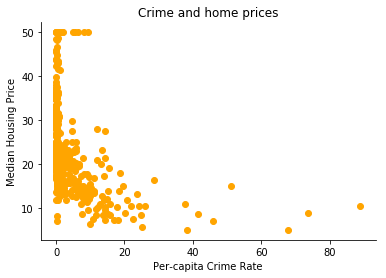

In [39]:
ax = plt.subplot(111)
plt.scatter(bdata.data[:,0], bdata.target, color="orange")
plt.ylabel('Median Housing Price')
plt.xlabel('Per-capita Crime Rate')
plt.title('Crime and home prices')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [40]:
# split data into train and test
x = bdata.data[:,0].reshape(-1,1) # reshape into (n, 1) arrays
y = bdata.target.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33)

from sklearn import linear_model
lm = linear_model.LinearRegression()

lm = lm.fit(X_train, y_train)

lm_pred = lm.predict(X_train)
print('RMSE of linear model on train set:', round(compute_rmse(lm_pred, y_train),3)) # calculate RMSE for training set

lm_pred = lm.predict(X_test) # now predict on the test set
print('RMSE of linear model on test set:', round(compute_rmse(lm_pred, y_test),3)) # calculate RMSE for test set

RMSE of linear model on train set: 8.6
RMSE of linear model on test set: 8.255


### 4.2 So many scatterplots!

Choose 8 out of the 14 features of the housing data that you think are most interesting to study.  Create an 8x8 grid of scatterplots showing how each of these variables relate to each other.  You want to produce something that looks generally like [this image](http://iogas.net/wp-content/gallery/iogas-evaluation/scatterplot-matrix-point-density.png).

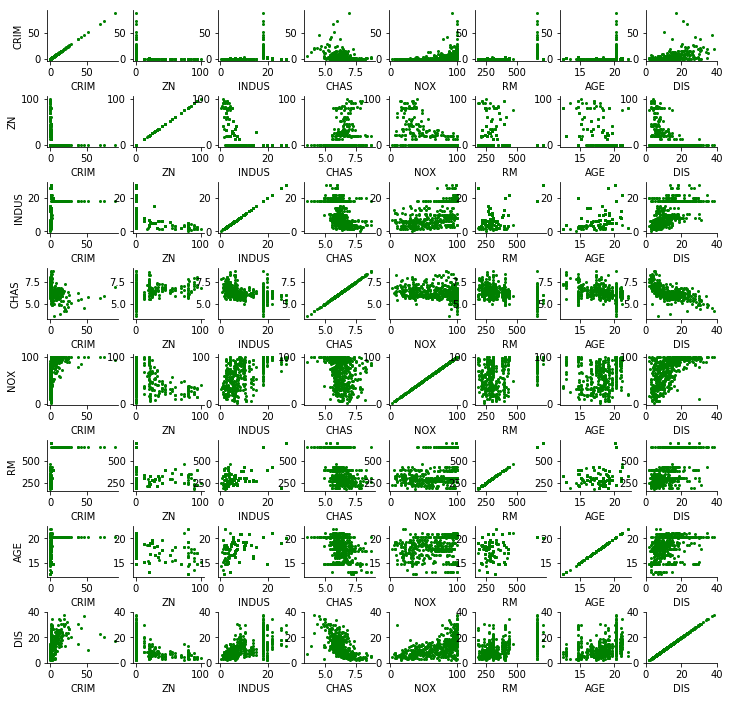

In [41]:
# First subset the features of interest
bdat_vars = bdata.data[:,np.where((bdata.feature_names == 'CRIM') | 
                      (bdata.feature_names == 'ZN') |
                     (bdata.feature_names == 'TAX') |
                     (bdata.feature_names == 'AGE') |
                     (bdata.feature_names == 'LSTAT') |
                     (bdata.feature_names == 'PTRATIO') |
                     (bdata.feature_names == 'INDUS') |
                     (bdata.feature_names == 'RM'))].reshape(-1,8)

plt.figure(figsize=(12,12)) # create figure size
plt.subplots_adjust(hspace=0.7) # adjust space between plots to allow for x-axis labels

for i in range(8):
    for j in range(8):
        ax = plt.subplot(8, 8, i * 8 + j + 1)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        plt.scatter(x = bdat_vars[:,j], y = bdat_vars[:,i], color="green", s=4) # create scatter plot
        if(j<1): # only plot y-axis labels for plots in first column
            plt.ylabel(bdata.feature_names[i])
        plt.xlabel(bdata.feature_names[j])
        
        

### 4.3 PCA to the rescue

Run principal component analysis using [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) from sklearn to find the first 12 principal components of your data.  Use only your training set (66% of the data), and use all features *except* the median housing price.  Create a figure showing how the amount of variance explained by your components increases as you increase the number of components from 1 to 12.

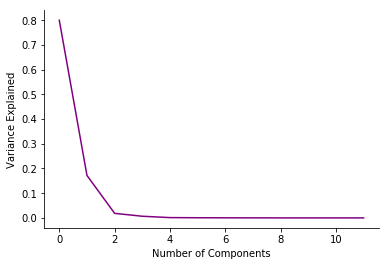

In [44]:
# Let's put our subsetted features into a dataframe with proper column names
bdat_df = pd.DataFrame(data=bdata.data, columns=[bdata.feature_names])

# Standardize the data (mean = 0, var = 1)
scaler = StandardScaler() # create scaler
bdat_scale = pd.DataFrame(scaler.fit_transform(bdat_df)) # standardize data and set as df

# Now we split data into train and test
X_train, X_test, y_train, y_test = train_test_split(bdat_df, bdata.target, test_size=0.33)

# Compute the first 12 PCs
pca = PCA(n_components=12).fit(X_train)

# Skreeplot
ax = plt.subplot(111)
plt.plot(pca.explained_variance_ratio_, color="purple")
plt.xlabel('Number of Components')
plt.ylabel('Variance Explained')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

### 4.4 Visualizing the components

Create a 1X3 grid containing three scatter plots of your training data:

1. PCA 1 vs. PCA 2 (you will need to use `fit_transform` to project your training data onto these two components)
2. PCA 1 (x-axis) vs. median housing value
3. PCA 2 vs. median housing value

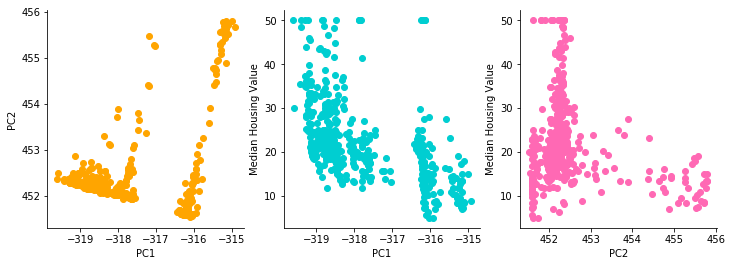

In [43]:
pca_trans = pca.transform(bdat_scale)

# PC1 vs. PC2 scaterplot
plt.figure(figsize=(12,4)) # create figure size
ax = plt.subplot(131)
plt.scatter(x=pca_trans[:,0], y=pca_trans[:,1], color="orange")
plt.xlabel('PC1')
plt.ylabel('PC2')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# PC1 vs. median housing value
ax = plt.subplot(132)
plt.scatter(x=pca_trans[:,0], y=bdata.target, color="darkturquoise")
plt.xlabel('PC1')
plt.ylabel('Median Housing Value')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# PC2 vs. median housing value
ax = plt.subplot(133)
plt.scatter(x=pca_trans[:,1], y=bdata.target, color="hotpink")
plt.xlabel('PC2')
plt.ylabel('Median Housing Value')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

### 4.5 Regression and PCA

Using just the first Principal Component learned on the training data, project all of your data (including the test data) onto this 1-dimensional subspace using the `fit_transform` function.  Now, using your training data, fit a regression of median housing price on this first principal component of your data.  Report the RMSE of this regression for both the training and test set.  How do these results compare to your results from 4.1?  Interpret your results!

In [45]:
# Fit our PCA to training and test data
pca = PCA(n_components=1) # create PCA object with only the first component

pca_train = pca.fit_transform(X_train) # fit to training data
lm = linear_model.LinearRegression()
lm = lm.fit(pca_train, y_train) # fit linear model using PC1 
lm_train_pred = lm.predict(pca_train)

pca_test = pca.fit_transform(X_test) # fit to test data
lm_test = linear_model.LinearRegression()
lm_test = lm.fit(pca_test, y_test) # fit linear model using PC1 
lm_test_pred = lm.predict(pca_test)

print('RMSE of linear model on train set:', round(compute_rmse(lm_train_pred, y_train),3)) # calculate RMSE for training set
print('RMSE of linear model on test set:', round(compute_rmse(lm_test_pred, y_test),3)) # calculate RMSE for training set

RMSE of linear model on train set: 7.744
RMSE of linear model on test set: 8.528


The model does better on the training set, but slightly worse on the test set using this method. This is probably because the PCA reduces the dimensionality and maximizes the variance between the features, getting rid of redundancy/extraneous features and allowing for a better fit on the training set. However, it is still basically the same information going into the model, so there is not much of an improvement on the test set.